# M2 - Random Forest Classifier (all features)

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost as xgb

from hyperopt import hp, tpe, Trials, fmin
from hyperopt.pyll.base import scope
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.pipeline import Pipeline
from joblib import dump

## Loading Dataset

In [29]:
#INPUT AND OUTPUT LOCATION FOLDER 
location = '/Users/klaaskorteweg/Desktop/Master Thesis/'

train = 'train_data_processed.xlsx'
test = 'test_data_processed.xlsx'

train_df = pd.read_excel(location+train)
test_df = pd.read_excel(location+test)

In [30]:
train_df.drop(columns=['date'], inplace=True)
train_df = train_df.astype(str)

test_df.drop(columns=['date'], inplace=True)
test_df = test_df.astype(str)

print(train_df.columns.tolist())

['iyear', 'imonth', 'iday', 'country_txt', 'region_txt', 'provstate', 'city', 'attacktype1_txt', 'targtype1_txt', 'gname', 'gsubname', 'weaptype1_txt', 'weapsubtype1_txt', 'crit1', 'crit2', 'crit3', 'multiple', 'suicide', 'individual', 'INT_MISC', 'weekday', 'quarter', 'weekend']


## Settings

In [31]:
#NAME AND CLASSIFIER ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
name = "Random Forest Classifier (all features)"
classifier = RandomForestClassifier(n_jobs=-1)

#TARGET AND FEATURES ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target = 'targtype1_txt'
variables = ['iyear', 'imonth', 'iday', 'country_txt', 'region_txt', 'provstate',
       'city', 'attacktype1_txt', 'gname', 'gsubname',
       'weaptype1_txt', 'weapsubtype1_txt', 'crit1', 'crit2', 'crit3',
       'multiple', 'suicide', 'individual', 'INT_MISC', 'weekday',
       'quarter', 'weekend']

#FEATURE SELECTION ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
selector = SelectKBest(score_func=chi2, k='all')

# TIME SERIES CROSS VALIDATION ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
k_time_series_splits = 5

#HYPERPARAMETER TUNING ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
evals = 40

space = {
    'classifier__n_estimators': scope.int(hp.quniform('classifier__n_estimators', 100, 500, 50)),
    'classifier__criterion': hp.choice('classifier__criterion', ['gini', 'entropy', 'log_loss']),
    'classifier__max_depth': scope.int(hp.quniform('classifier__max_depth', 3, 30, 2)),
    'classifier__min_samples_split': scope.int(hp.quniform('classifier__min_samples_split', 2, 20, 2)),
    'classifier__min_samples_leaf': scope.int(hp.quniform('classifier__min_samples_leaf', 2, 20, 2)),
    'classifier__max_features': hp.choice('classifier__max_features', ['sqrt', 'log2', None])
}
# !!! Also adjust the best_parameters according to the hyperparameter search space !!!

## Time Series Cross Validation Split

In [32]:
print("Number of splits:",k_time_series_splits)

tscv = TimeSeriesSplit(n_splits=k_time_series_splits) 

for i, (train_index, val_index) in enumerate(tscv.split(train_df)):
    print(f"Split {i}")
    print(f"Train: index={train_index}")
    print(f"Validation: index={val_index}")

Number of splits: 5
Split 0
Train: index=[    0     1     2 ... 27178 27179 27180]
Validation: index=[27181 27182 27183 ... 54354 54355 54356]
Split 1
Train: index=[    0     1     2 ... 54354 54355 54356]
Validation: index=[54357 54358 54359 ... 81530 81531 81532]
Split 2
Train: index=[    0     1     2 ... 81530 81531 81532]
Validation: index=[ 81533  81534  81535 ... 108706 108707 108708]
Split 3
Train: index=[     0      1      2 ... 108706 108707 108708]
Validation: index=[108709 108710 108711 ... 135882 135883 135884]
Split 4
Train: index=[     0      1      2 ... 135882 135883 135884]
Validation: index=[135885 135886 135887 ... 163058 163059 163060]


## Encoding & Pipeline

In [33]:
#Seperating variables and target for train and testing set
X_train = train_df[variables]
y_train = train_df[target]
X_test = test_df[variables]
y_test = test_df[target]

#Encoding target variable for train and testing set
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#Encoding features for pipeline 
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(handle_unknown='ignore'), variables)
        ],
    remainder='drop'
)

#Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector',selector),
    ('classifier', classifier) 
    ])

## Hyperparameter Tuning
Hyperopt with Bayesian optimization

In [34]:
def objective(params):
    pipeline.set_params(**params)
    scores = cross_val_score(pipeline, X_train, y_train_encoded, cv=tscv, scoring='accuracy')
    return -scores.mean()  

trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=evals, trials=trials)

print("Best hyperparameters:", best)


100%|██████████| 40/40 [5:54:57<00:00, 532.44s/trial, best loss: -0.4714895496025905]   
Best hyperparameters: {'classifier__criterion': 2, 'classifier__max_depth': 22.0, 'classifier__max_features': 2, 'classifier__min_samples_leaf': 2.0, 'classifier__min_samples_split': 10.0, 'classifier__n_estimators': 400.0}


In [35]:
best_params = {
    'classifier__n_estimators': int(best['classifier__n_estimators']),
    'classifier__criterion': ['gini', 'entropy', 'log_loss'][best['classifier__criterion']],
    'classifier__max_depth': int(best['classifier__max_depth']),
    'classifier__min_samples_split': int(best['classifier__min_samples_split']),
    'classifier__min_samples_leaf': int(best['classifier__min_samples_leaf']),
    'classifier__max_features': ['sqrt','log2',None][best['classifier__max_features']]
}

print(best_params)

pipeline.set_params(**best_params)
pipeline.fit(X_train, y_train_encoded)

{'classifier__n_estimators': 400, 'classifier__criterion': 'log_loss', 'classifier__max_depth': 22, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_features': None}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['iyear', 'imonth', 'iday',
                                                   'country_txt', 'region_txt',
                                                   'provstate', 'city',
                                                   'attacktype1_txt', 'gname',
                                                   'gsubname', 'weaptype1_txt',
                                                   'weapsubtype1_txt', 'crit1',
                                                   'crit2', 'crit3', 'multiple',
                                                   'suicide', 'individual',
                                                   'INT_MISC', 'weekday',
                                                   'quarter', 'weekend'])])),
                ('selector',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x1657894e0>)),
                ('classifier',
                 RandomForestClassifier(criterion='log_loss', max_depth=22,
                                        max_features=None, min_samples_leaf=2,
                                        min_samples_split=10, n_estimators=400,
                                        n_jobs=-1))])

In [36]:
cv_scores_after_opt = cross_val_score(pipeline, X_train, y_train_encoded, cv=tscv, scoring='accuracy')
print("Tuned Model ({}):".format(name))
print("Cross-validation scores (best param.):", cv_scores_after_opt)
print("Mean CV score (best param.):", cv_scores_after_opt.mean())

Tuned Model (Random Forest Classifier (all features)):
Cross-validation scores (best param.): [0.48465558 0.40373859 0.40355461 0.49908007 0.56075213]
Mean CV score (best param.): 0.4703561966440978


In [37]:
opt_test_accuracy = pipeline.score(X_test, y_test_encoded)
opt_train_accuracy = pipeline.score(X_train, y_train_encoded)

opt_train_predictions = pipeline.predict(X_train)
opt_test_predictions = pipeline.predict(X_test)

print("Tuned Model ({}):".format(name))
print("Train accuracy",opt_train_accuracy)
print("Test accuracy",opt_test_accuracy)


Tuned Model (Random Forest Classifier (all features)):
Train accuracy 0.6795493710942531
Test accuracy 0.5976793088596691


## Summary

In [38]:
print(name)
print()
print("Time Series Split:")
print('- Number of splits:',k_time_series_splits)
print('- Split Indices:')
split_info = {}
for i, (train_index, val_index) in enumerate(tscv.split(train_df)):
    split_info[f"Split {i}"] = {'Train': f"{train_index[0]}-{train_index[-1]}", 'Val': f"{val_index[0]}-{val_index[-1]}"}
print(" ",split_info)
print()

print("Hyperparameter Tuning:")
print("- Parameter Grid:",space)
print("- Best Parameters:",best_params)

print()
print("Tuned Model:")
print("- TSCV scores (best param.):", cv_scores_after_opt)
print("- Mean TSCV score (best param.):", cv_scores_after_opt.mean())
print("- Training set accuracy:", opt_train_accuracy)
print("- Testing set accuracy:",opt_test_accuracy)


Random Forest Classifier (all features)

Time Series Split:
- Number of splits: 5
- Split Indices:
  {'Split 0': {'Train': '0-27180', 'Val': '27181-54356'}, 'Split 1': {'Train': '0-54356', 'Val': '54357-81532'}, 'Split 2': {'Train': '0-81532', 'Val': '81533-108708'}, 'Split 3': {'Train': '0-108708', 'Val': '108709-135884'}, 'Split 4': {'Train': '0-135884', 'Val': '135885-163060'}}

Hyperparameter Tuning:
- Parameter Grid: {'classifier__n_estimators': <hyperopt.pyll.base.Apply object at 0x285105f10>, 'classifier__criterion': <hyperopt.pyll.base.Apply object at 0x2851063d0>, 'classifier__max_depth': <hyperopt.pyll.base.Apply object at 0x2851068d0>, 'classifier__min_samples_split': <hyperopt.pyll.base.Apply object at 0x285106dd0>, 'classifier__min_samples_leaf': <hyperopt.pyll.base.Apply object at 0x2851072d0>, 'classifier__max_features': <hyperopt.pyll.base.Apply object at 0x285107790>}
- Best Parameters: {'classifier__n_estimators': 400, 'classifier__criterion': 'log_loss', 'classifier_

## Error checks

In [39]:
def check_encoding(Y_train, Y_train_encoded, Y_test, Y_test_encoded):
    train_label_map = {val: label for val, label in zip(Y_train_encoded, Y_train)}
    test_label_map = {val: label for val, label in zip(Y_test_encoded, Y_test)}

    for val in set(Y_train_encoded) | set(Y_test_encoded):
        train_label = train_label_map.get(val)
        test_label = test_label_map.get(val)

        if train_label is None:
            print(f"Value {val} is present in test set but not in train set.")
        elif test_label is None:
            print(f"Value {val} is present in train set but not in test set.")
        elif train_label == test_label:
            print(f"Value {val}: {train_label} == {test_label} -- Check")
        else:
            print(f"Value {val}: {train_label} != {test_label} -- NOT EQUAL")


check_encoding(y_train, y_train_encoded, y_test, y_test_encoded)

Value 0: Business == Business -- Check
Value 1: Government (General) == Government (General) -- Check
Value 2: Military == Military -- Check
Value 3: Other == Other -- Check
Value 4: Police == Police -- Check
Value 5: Private Citizens & Property == Private Citizens & Property -- Check


## Error Analysis

[[ 9592   796    43  4792  1322  3187]
 [ 1458  9916    68  3507  2025  3136]
 [  101   284 21793   664  1027  1179]
 [ 1627  1778    68 25798  2260  4503]
 [  715  1488    87  2222 14129  3928]
 [ 1241  1696    71  4311  2669 29580]]


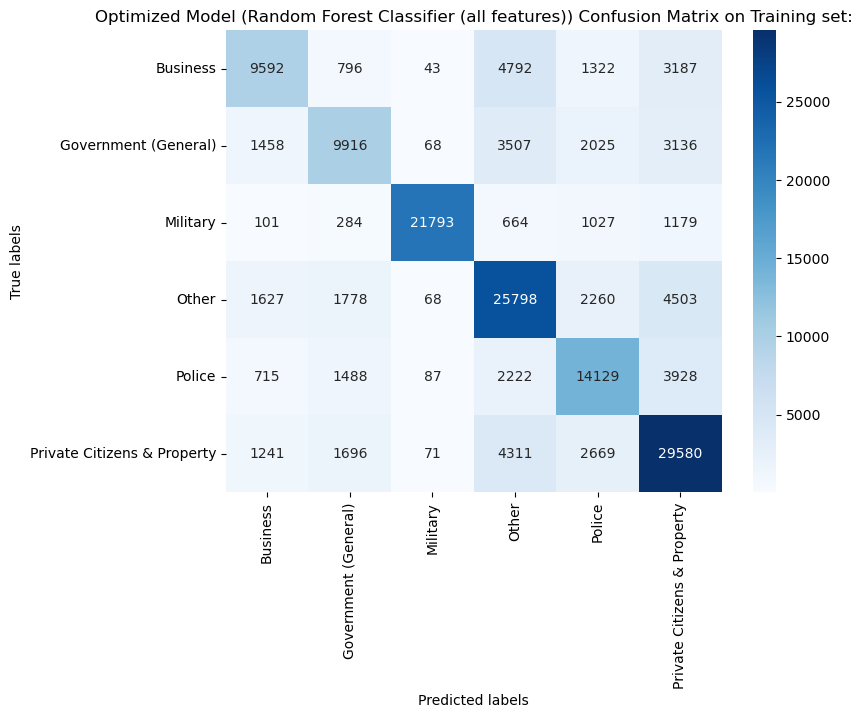

In [40]:

cm = confusion_matrix(y_train_encoded, opt_train_predictions)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title("Optimized Model ({}) Confusion Matrix on Training set:".format(name))
plt.show()

[[ 344  101   15  635  329 1013]
 [  91 1541   21  502  600  963]
 [  23   95 7886  193  370  516]
 [ 252  593   51 2328  854 1739]
 [  70  383  114  525 3081 1826]
 [ 190  761   44 1369 1642 8411]]


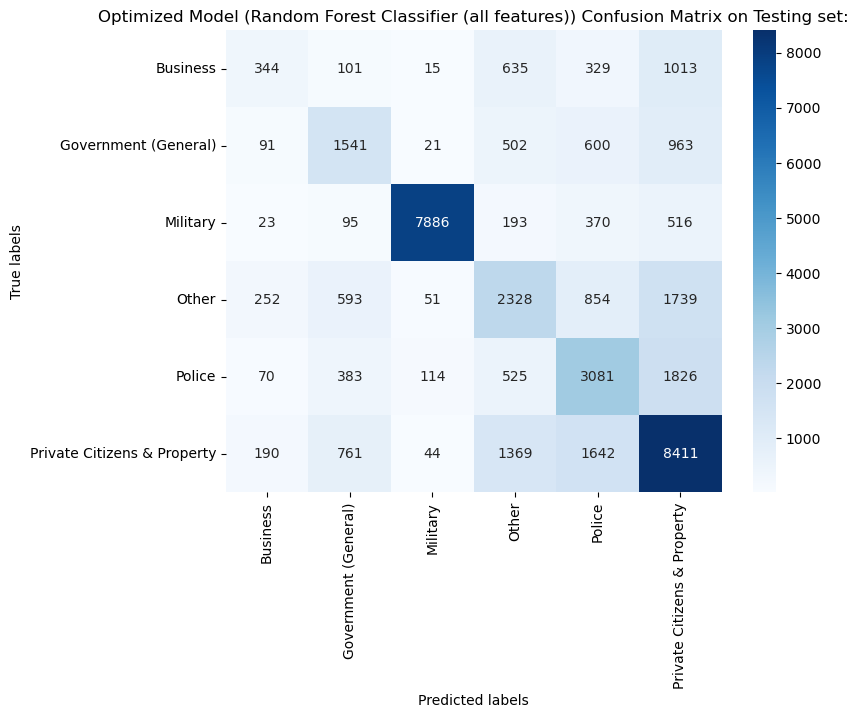

In [41]:

cm = confusion_matrix(y_test_encoded, opt_test_predictions)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title("Optimized Model ({}) Confusion Matrix on Testing set:".format(name))
plt.show()

In [42]:
train_report = classification_report(y_train_encoded, opt_train_predictions)
print("Optimized Model ({}) Classification Report on Training set:".format(name))
print(train_report)

test_report = classification_report(y_test_encoded, opt_test_predictions)
print("Optimized Model ({}) Classification Report on Testing set:".format(name))
print(test_report)

Optimized Model (Random Forest Classifier (all features)) Classification Report on Training set:
              precision    recall  f1-score   support

           0       0.65      0.49      0.56     19732
           1       0.62      0.49      0.55     20110
           2       0.98      0.87      0.92     25048
           3       0.62      0.72      0.67     36034
           4       0.60      0.63      0.61     22569
           5       0.65      0.75      0.70     39568

    accuracy                           0.68    163061
   macro avg       0.69      0.66      0.67    163061
weighted avg       0.69      0.68      0.68    163061

Optimized Model (Random Forest Classifier (all features)) Classification Report on Testing set:
              precision    recall  f1-score   support

           0       0.35      0.14      0.20      2437
           1       0.44      0.41      0.43      3718
           2       0.97      0.87      0.92      9083
           3       0.42      0.40      0.41    

## Save Pipeline

In [43]:
filename = name + '.joblib'

dump(pipeline, filename)

['Random Forest Classifier (all features).joblib']

## Feature Importance Analysis

In [44]:
try:
    feature_importances = pipeline.named_steps['classifier'].feature_importances_
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()


    feature_names = [name.split('_', 2)[-1] for name in feature_names]


    sorted_importances = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

    print("Feature Importances:")
    for feature_name, importance in sorted_importances:
        print(f"{feature_name}: {importance}")
except AttributeError:
 
    raise ValueError("Feature importances are not available for the chosen classifier.")


Feature Importances:
crit3_0: 0.1643243479160124
crit3_1: 0.15486785931991862
attacktype1_txt_Assassination: 0.018601375723432793
attacktype1_txt_Armed Assault: 0.018333260999918454
region_txt_Middle East & North Africa: 0.016210807330064046
city_Other: 0.013722342056359077
INT_MISC_0: 0.01297588682400588
region_txt_South Asia: 0.012389789569891962
INT_MISC_1: 0.012275613276477283
gname_Unknown: 0.01074179834982536
weapsubtype1_txt_Unknown Explosive Type: 0.009525023402996696
region_txt_Sub-Saharan Africa: 0.008839900569790863
provstate_Other: 0.007081454437753161
quarter_Q2: 0.007010674833850602
attacktype1_txt_Hostage Taking (Kidnapping): 0.006888075941197993
provstate_northern ireland: 0.006806871121769558
iyear_2015: 0.006680815448127302
weekday_Monday: 0.00664282005929758
multiple_1: 0.006618670658447017
quarter_Q3: 0.006603733943621323
multiple_0: 0.006585767801752006
attacktype1_txt_Facility/Infrastructure Attack: 0.006525899623524166
region_txt_Western Europe: 0.006417019262222

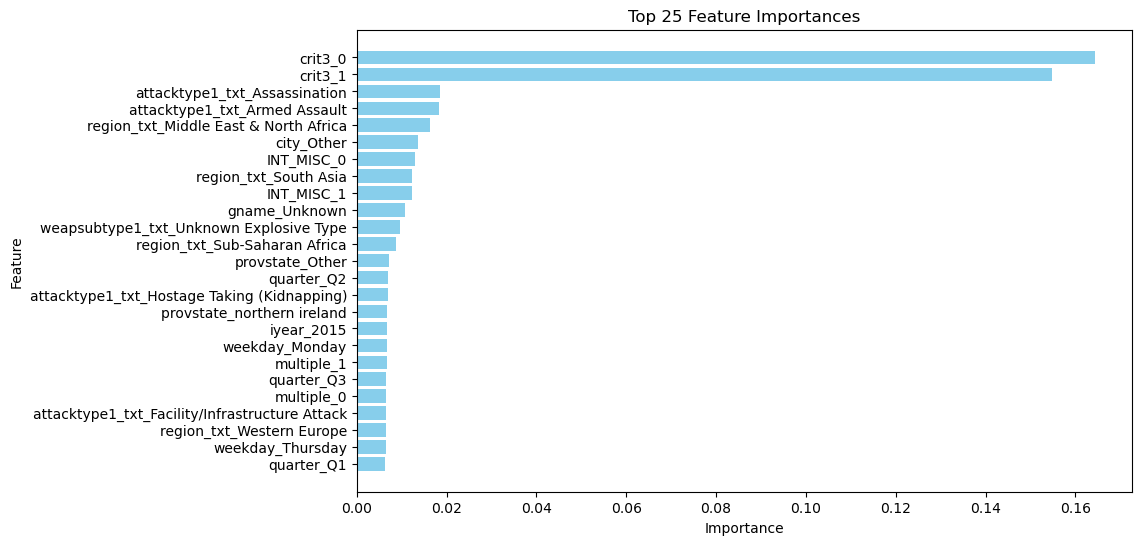

In [45]:

top_features_count = 25


top_features = [feature_name for feature_name, _ in sorted_importances[:top_features_count]]
top_importances = [importance for _, importance in sorted_importances[:top_features_count]]


plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_features_count} Feature Importances')
plt.gca().invert_yaxis()  
plt.show()


## Hyperparameter Graph

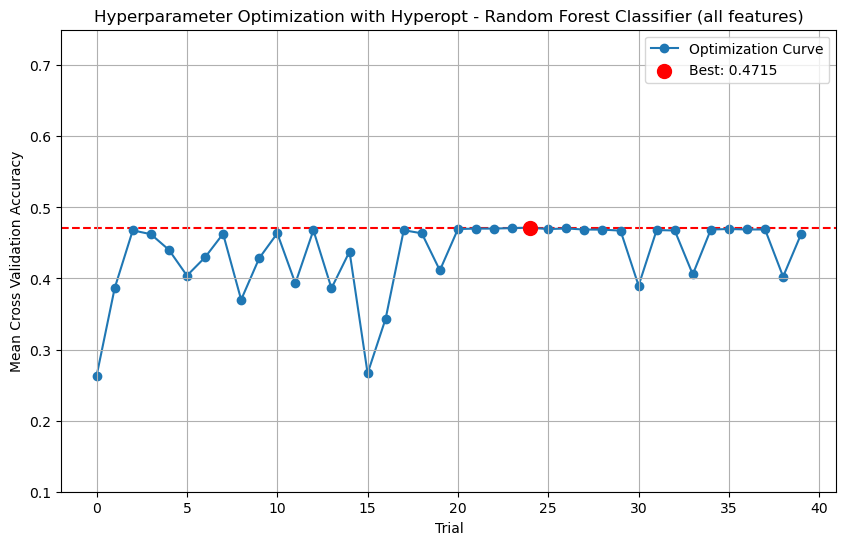

In [46]:
import matplotlib.pyplot as plt

losses = [-trial['result']['loss'] for trial in trials.trials]


plt.figure(figsize=(10, 6))
plt.plot(losses, marker='o', linestyle='-', label='Optimization Curve', zorder=1) 
plt.xlabel('Trial')
plt.ylabel('Mean Cross Validation Accuracy')
plt.title(f'Hyperparameter Optimization with Hyperopt - {name}')
plt.grid(True)


plt.ylim(0.1, 0.75)

best_iteration = len(losses) - 1 - losses[::-1].index(max(losses))  
best_loss = max(losses)


plt.scatter([best_iteration], [best_loss], color='red', label=f'Best: {best_loss:.4f}', s=100, marker='o', zorder=2)  # Higher zorder to plot in front


plt.axhline(y=best_loss, color='red', linestyle='--', zorder=0) 

plt.legend()

plt.show()

In [47]:
print(pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['iyear', 'imonth', 'iday',
                                                   'country_txt', 'region_txt',
                                                   'provstate', 'city',
                                                   'attacktype1_txt', 'gname',
                                                   'gsubname', 'weaptype1_txt',
                                                   'weapsubtype1_txt', 'crit1',
                                                   'crit2', 'crit3', 'multiple',
                                                   'suicide', 'individual',
                                                   'INT_MISC', 'weekday',
                                                   'quarter', 'weekend'])])),
                ('selector',
         